<font color=darkgreen>
    
# Ex8-1.  Visualizing CNN

강지상 님의 사진의 어떤 부분이 90% 이상 강아지로 인식되게 만들었을까? 사전에 학습된 개/고양이 분류 모델을 불러와서 확인해보자.

#### 모델 불러오기

In [1]:
from keras.models import load_model
model=load_model('cats_and_dogs_small_2.h5')

Using TensorFlow backend.


#### 사진을 전처리 후 모델에 입력하여 예측

Prob(dog): 0.966866


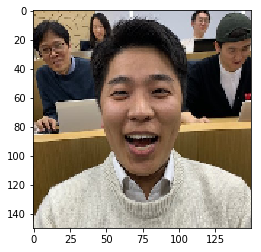

In [26]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np 

img_path = 'figures/jskang.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.

pred=model.predict(x)
print('Prob(dog): %f'%(pred))

#### Grad-CAM을 적용

<font color=blue>

TO DO:
- 불러온 모델의 summary를 프린트 하여 모델을 확인
- 모델의 output tensor를 `class_output`에 저장
- flatten 직전의 layer를 `last_conv_layer`이름으로 저장(hint: `model.get_layer`의 `name` 옵션 대신 `index` 옵션 사용 https://keras.io/models/model/) 

In [27]:
model.layers

In [45]:
# Your answer comes here.
class_output = model.output
last_conv_layer = model.get_layer(index=6)

In [46]:
# 원하는 layer의 output shape을 가지고 있는지 확인 
last_conv_layer.output_shape

(None, 15, 15, 128)

<font color=blue>
    
TO DO: `class_output`을 `last_conv_layer`의 output tensor로 미분하는 gradient를 `grads` 이름으로 저장 

In [47]:
# Your answer comes here.

import keras.backend as K 
grads = K.gradients(class_output, last_conv_layer.output)[0]  
pooled_grads = K.mean(grads, axis=(0, 1, 2))


In [48]:
# 각 feature map에 대한 가중치 계산하고 가중 평균 계산 
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x]) 

for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

#### 히트맵으로 시각화

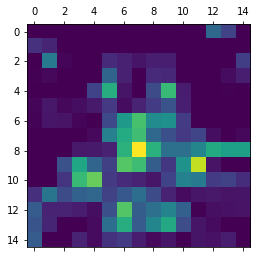

In [49]:

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

#### 히트맵을 원본 사진과 함께 프린트 
- 강지상 님의 사진은 왜 강아지로 판별된 것으로 보이는가?

In [50]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('./class_act.jpg', superimposed_img)

True